# Import Library

In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.constraints import max_norm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import time

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Data Preprocessing

In [2]:
data = pd.read_csv("D:/SGCC/data.csv")
print("number of the customers (total): " + str(len(data)))
print("number of normal electricity customers: " + str(np.sum(data["FLAG"]==0)))
print("number of electricity thieves: " + str(np.sum(data["FLAG"]==1)))

# sort by date
date_dict = {}
for date in data.columns[2:]:
  date_dict[date] = pd.to_datetime(date, format = '%Y/%m/%d').strftime('%Y-%m-%d')

data_sort = data.rename(columns=date_dict)
data_sort = data_sort.T
data_sort.sort_index(inplace=True)
data_sort = data_sort.T

second_column = data_sort.pop('FLAG')
data_sort.insert(0, 'FLAG', second_column)

first_column = data_sort.pop('CONS_NO')
data_sort.insert(0, 'CONS_NO', first_column)

number of the customers (total): 42372
number of normal electricity customers: 38757
number of electricity thieves: 3615


C:\Users\ivanlim\anaconda3\envs\ntl\lib\site-packages\IPython\core\interactiveshell.py:3364: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
display(data_sort)

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.3,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.2,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.1,6.73,7.52,10.89,9.86,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,F1472871E1AFF49D4289564B6377D76C,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.1,2.75,3.01,2.99,2.83,2.54,3.4,3.59,2.54
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.7,0.0,0.0,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.7,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65
42370,D9A6ADA018FA46A55D5438370456AA45,0,16.89,15.15,19.28,17.19,16.8,17.48,17.86,23.99,...,15.64,16.48,13.04,10.39,12.0,11.15,12.22,13.16,13.33,10.39


In [4]:
# remove unnecessary feature
data_sort.pop("CONS_NO")
display(data_sort)

# data cleaning using imputation method
def data_cleaning(x):
  check_null = x.isnull()
  for i in range(len(x))[1:]:
    if check_null[i]:
      if i == 1 or i == len(x)-1:
        x[i] = 0
      else:
        if check_null[i-1] or check_null[i+1]:
          x[i] = 0
        else:
          x[i] = (x[i-1] + x[i+1]) / 2 
  return x

data_clean = data_sort.copy(deep=True)
data_clean.apply(data_cleaning, axis=1)
display(data_clean)

,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.3,7.54,9.16,6.74
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.2,13.66
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,...,14.21,10.22,8.47,6.11,6.1,6.73,7.52,10.89,9.86,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.1,2.75,3.01,2.99,2.83,2.54,3.4,3.59,2.54
42368,0,2.7,0.0,0.0,5.72,6.05,5.81,3.07,4.04,5.68,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.7,1.23,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65
42370,0,16.89,15.15,19.28,17.19,16.8,17.48,17.86,23.99,12.34,...,15.64,16.48,13.04,10.39,12.0,11.15,12.22,13.16,13.33,10.39


,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,1,0,0,0,0,0,0,0,0,0,...,7.18,8.07,8.09,9.53,5.48,8.75,9.3,7.54,9.16,6.74
1,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.2,13.66
3,1,0,0,0,0,0,0,0,0,0,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,...,14.21,10.22,8.47,6.11,6.1,6.73,7.52,10.89,9.86,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,0,0,0,0,0,0,0,0,0,0,...,3.27,3.1,2.75,3.01,2.99,2.83,2.54,3.4,3.59,2.54
42368,0,2.7,0.0,0.0,5.72,6.05,5.81,3.07,4.04,5.68,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.7,1.23,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65
42370,0,16.89,15.15,19.28,17.19,16.8,17.48,17.86,23.99,12.34,...,15.64,16.48,13.04,10.39,12.0,11.15,12.22,13.16,13.33,10.39


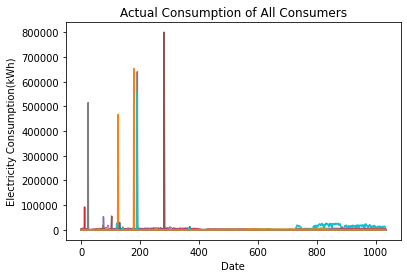

In [5]:
for i in range(data_clean.shape[0]):
  plt.plot(range(data_clean.shape[1]-1), data_clean.iloc[i, 1:])

plt.xlabel('Date') 
plt.ylabel('Electricity Consumption(kWh)') 
plt.title("Actual Consumption of All Consumers") 
plt.show()

In [6]:
# remove outliers
def remove_outliers(x):
  mean = x[1:].mean()
  std = x[1:].std()

  for i in range(len(x))[1:]:
    if std > 100:
      x[i] = 0
    elif x[i] > mean + 2*std:
      x[i] = mean + 2*std

data_remove_outliers = data_clean.copy(deep=True)
data_remove_outliers.apply(remove_outliers, axis=1)
display(data_remove_outliers)

,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,1,0,0,0,0,0,0,0,0,0,...,7.18,8.07,8.09,9.53,5.48,8.75,9.3,7.54,9.16,6.74
1,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,10.95,13.462118,13.462118,13.462118,13.462118,13.462118,13.462118,13.462118,13.462118,13.462118
3,1,0,0,0,0,0,0,0,0,0,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,...,14.21,10.22,8.47,6.11,6.1,6.73,7.52,10.89,9.86,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,0,0,0,0,0,0,0,0,0,0,...,3.27,3.1,2.75,3.01,2.99,2.83,2.54,3.4,3.59,2.54
42368,0,2.7,0.0,0.0,5.72,6.05,5.81,3.07,4.04,5.68,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.7,1.23,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65
42370,0,16.89,15.15,19.28,17.19,16.8,17.48,17.86,23.99,12.34,...,15.64,16.48,13.04,10.39,12.0,11.15,12.22,13.16,13.33,10.39


In [7]:
cut_ratio = 50
all_zeros = 0
ones = 0
zeros = 0
drop_index = []
for i in range(len(data_remove_outliers)):
  if np.sum(data_remove_outliers.iloc[i, 1:] == 0) >= cut_ratio / 100 * (data_remove_outliers.shape[1]-1):
    drop_index.append(i)
    all_zeros += 1
    if data_remove_outliers.iloc[i, 0] == 1:
      ones += 1
    else:
      zeros += 1

data_final = data_remove_outliers.copy(deep=True)
data_final.drop(drop_index, inplace=True)
display(data_final)
print("number of the customers (total): " + str(len(data_final)))
print("number of normal electricity customers: " + str(np.sum(data_final["FLAG"]==0)))
print("number of electricity thieves: " + str(np.sum(data_final["FLAG"]==1)))

,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,1,0,0,0,0,0,0,0,0,0,...,7.18,8.07,8.09,9.53,5.48,8.75,9.3,7.54,9.16,6.74
4,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,...,14.21,10.22,8.47,6.11,6.1,6.73,7.52,10.89,9.86,8.72
6,1,0.11,0.11,0.25,0.27,0.21,0.2,0.14,0.34,0.23,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.4
7,1,0.91,1.16,0.75,1.3,0.74,0.94,0.85,1.21,1.17,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
9,1,11.02,7.92,8.41,9.66,9.86,8.32,8.21,7.88,10.17,...,64.11,84.89,60.86,52.67,49.43,57.22,56.68,45.28,44.04,43.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42366,0,0,0,0,0,0,0,0,0,0,...,0.59,0.95,0.39,0.86,0.6,0.82,0.65,0.53,0.77,0.56
42367,0,0,0,0,0,0,0,0,0,0,...,3.27,3.1,2.75,3.01,2.99,2.83,2.54,3.4,3.59,2.54
42368,0,2.7,0.0,0.0,5.72,6.05,5.81,3.07,4.04,5.68,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.7,1.23,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


number of the customers (total): 25357
number of normal electricity customers: 23292
number of electricity thieves: 2065


# Visualising Data

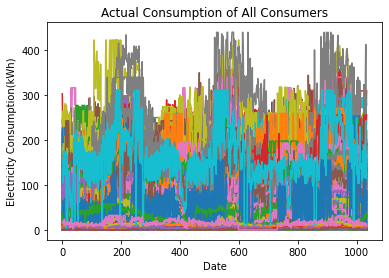

In [8]:
for i in range(data_final.shape[0]):
  plt.plot(range(data_final.shape[1]-1), data_final.iloc[i, 1:])

plt.xlabel('Date') 
plt.ylabel('Electricity Consumption(kWh)') 
plt.title("Actual Consumption of All Consumers") 
plt.savefig("Actual Consumption of All Consumers.png",dpi=1200)
plt.show()

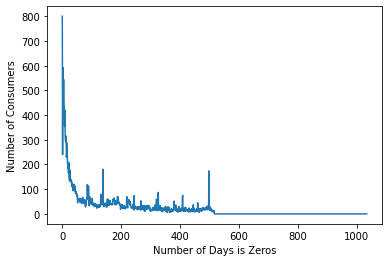

{0: 800, 1: 240, 2: 593, 3: 449, 4: 545, 5: 540, 6: 444, 7: 425, 8: 354, 9: 420, 10: 309, 11: 293, 12: 291, 13: 315, 14: 229, 15: 243, 16: 286, 17: 232, 18: 203, 19: 186, 20: 206, 21: 165, 22: 208, 23: 145, 24: 140, 25: 133, 26: 178, 27: 144, 28: 136, 29: 130, 30: 138, 31: 135, 32: 111, 33: 117, 34: 125, 35: 113, 36: 94, 37: 97, 38: 100, 39: 116, 40: 109, 41: 120, 42: 93, 43: 111, 44: 107, 45: 83, 46: 91, 47: 84, 48: 79, 49: 80, 50: 70, 51: 80, 52: 45, 53: 64, 54: 61, 55: 56, 56: 59, 57: 62, 58: 62, 59: 51, 60: 55, 61: 46, 62: 63, 63: 60, 64: 55, 65: 59, 66: 42, 67: 61, 68: 52, 69: 66, 70: 67, 71: 45, 72: 57, 73: 59, 74: 47, 75: 42, 76: 57, 77: 43, 78: 36, 79: 28, 80: 40, 81: 37, 82: 51, 83: 66, 84: 71, 85: 118, 86: 83, 87: 60, 88: 59, 89: 113, 90: 64, 91: 33, 92: 56, 93: 70, 94: 59, 95: 54, 96: 41, 97: 43, 98: 53, 99: 43, 100: 39, 101: 63, 102: 55, 103: 43, 104: 44, 105: 33, 106: 39, 107: 42, 108: 42, 109: 33, 110: 29, 111: 41, 112: 34, 113: 35, 114: 40, 115: 30, 116: 34, 117: 30, 118

In [9]:
number_of_zeros = {}
for i in range(data_final.shape[1]):
  number_of_zeros[i] = 0

for i in np.sum(data_final.iloc[:, 1:] == 0, axis=1):
  number_of_zeros[i] += 1

plt.plot(range(len(number_of_zeros)), list(number_of_zeros.values()))
plt.xlabel('Number of Days is Zeros') 
plt.ylabel('Number of Consumers') 
plt.title("") 
plt.show()

print(number_of_zeros)

# Periodic data

(25357, 1034)
(25357,)


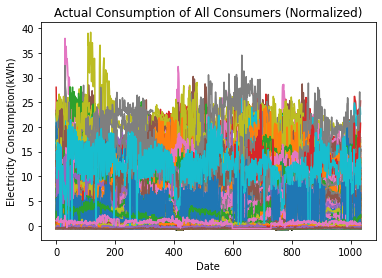

(25357, 148, 7)


In [10]:
X = data_final.iloc[:, 1:].to_numpy(dtype=np.float32)
print(X.shape)

Y = data_final.iloc[:, 0].to_numpy(dtype=np.float32)
print(Y.shape)

# standard scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

for i in range(X.shape[0]):
  plt.plot(range(X.shape[1]), X[i])
plt.xlabel('Date') 
plt.ylabel('Electricity Consumption(kWh)') 
plt.title("Actual Consumption of All Consumers (Normalized)") 
plt.savefig("Actual Consumption of All Consumers (Normalized).png",dpi=1200)
plt.show()

# pad 2 zeros to have 148 weeks
X = np.concatenate((X, np.zeros((X.shape[0], 2))), axis=1)

# period = 7 daysb
X = X.reshape(X.shape[0], -1, 7)
print(X.shape)

In [11]:
# split data into training and testing set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=99, stratify=Y)
print("number of class 0 in training set: " + str(np.sum(Y_train==0)))
print("number of class 1 in training set: " + str(np.sum(Y_train==1)))
print("number of class 0 in testing set: " + str(np.sum(Y_test==0)))
print("number of class 1 in testing set: " + str(np.sum(Y_test==1)))

number of class 0 in training set: 18633
number of class 1 in training set: 1652
number of class 0 in testing set: 4659
number of class 1 in testing set: 413


In [12]:
"""
Save & Load Real Data
"""
#np.savez_compressed('real_data', X=X, Y=Y)

#loaded = np.load('real_data.npz')
#print(loaded['X'].shape)
#print(loaded['Y'].shape)

"""
Load Fake Data
"""
fake_X = torch.load('fake data/fake_X.trc').cpu().detach().numpy()
fake_Y = torch.load('fake data/fake_Y.trc').cpu().detach().numpy()
print(fake_X.shape)
print(fake_Y.shape)

(40000, 148, 7)
(40000,)


In [13]:
batch_size = 32
buffer_size = 512
max_pred = 151
insert_fake_data = False

In [14]:
# finetuning
if insert_fake_data: 
    # insert 20000 class 1 fake data
    X_train = np.concatenate((X_train, fake_X[fake_Y==1]), axis=0)
    Y_train = np.concatenate((Y_train, fake_Y[fake_Y==1]), axis=0)
    print("number of class 0 in training set: " + str(np.sum(Y_train==0)))
    print("number of class 1 in training set: " + str(np.sum(Y_train==1)))
    print("number of class 0 in testing set: " + str(np.sum(Y_test==0)))
    print("number of class 1 in testing set: " + str(np.sum(Y_test==1)))
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
batched_dataset_train = dataset_train.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
batched_dataset_test = dataset_test.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)

# pretraining
dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
batched_dataset = dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)

number of class 0 in training set: 18633
number of class 1 in training set: 21652
number of class 0 in testing set: 4659
number of class 1 in testing set: 413


In [15]:
# batch
# split into first half and second half
# TODO: try random split

def make_batch(X, Y):
  batch = []
  positive = negative = 0
  CLS = np.ones((1, 7))
  SEP = np.ones((1, 7))*-1
  MASK = np.ones((1, 7))*0.5
  while positive != batch_size/2 or negative != batch_size/2:
    first = np.random.randint(X.shape[0])
    second = np.random.randint(X.shape[0])

    first_X = X[first][:X[first].shape[0]//2, :]
    second_X = X[second][X[second].shape[0]//2:, :]
    first_Y = first
    second_Y = second

    # CLS(1) first SEP(-1) second SEP(-1)
    input_ids = np.concatenate((CLS, first_X, SEP, second_X, SEP), axis=0)
    segment_ids = [0] * (1 + len(first_X) + 1) + [1] * (len(second_X) + 1)
    
    # MASK LM
    n_pred = int(len(input_ids) * 0.15) # 15
    cand_masked_pos = [i for i, token in enumerate(input_ids) if (token != CLS).all() and (token != SEP).all()]
    np.random.shuffle(cand_masked_pos)
    masked_tokens, masked_pos = [], []
    for pos in cand_masked_pos[:n_pred]:
      masked_pos.append(pos)
      masked_tokens.append(input_ids[pos].copy())
      if np.random.rand() < 0.8:  # 80%
        input_ids[pos] = MASK # make mask
      else:  # 20%
        input_ids[pos] = np.random.rand(1, 7) # random number from uniform distribution
    
    if first_Y == second_Y and positive < batch_size/2:
      batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
      positive += 1
    elif first_Y != second_Y and negative < batch_size/2:
      batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
      negative += 1

  input_ids = np.array([x[0] for x in batch])
  segment_ids = np.array([x[1] for x in batch])
  masked_tokens = np.array([x[2] for x in batch])
  masked_pos = np.array([x[3] for x in batch])
  label = np.array([x[4] for x in batch])
  
  return input_ids, segment_ids, masked_tokens, masked_pos, label

def tf_make_batch(X, Y):
  data = tf.py_function(make_batch, [X, Y], [tf.float32, tf.float32, tf.float32, tf.int32, tf.int32])
  return data

token_dataset = batched_dataset.map(tf_make_batch).prefetch(tf.data.AUTOTUNE)

for input_ids, segment_ids, masked_tokens, masked_pos, label in token_dataset.take(1):
  print(input_ids.shape, segment_ids.shape, masked_tokens.shape, masked_pos.shape, label.shape)
  #print(input_ids, segment_ids, masked_tokens, masked_pos, label)
  None

# for batch in batched_dataset.take(1):
#   new_batch = make_batch(batch)
#   input_ids = np.array([x[0] for x in new_batch])
#   segment_ids = np.array([x[1] for x in new_batch])

(32, 151, 7) (32, 151) (32, 22, 7) (32, 22) (32,)


In [16]:
# batch
# get token, segment and label

def make_batch_finetune(X, Y):
  batch = []
  positive = negative = 0
  CLS = np.ones((1, 7))
  SEP = np.ones((1, 7))*-1
  MASK = np.ones((1, 7))*0.5

  input_ids = np.concatenate((np.ones((X.shape[0], 1, 7)), X,  np.ones((X.shape[0], 1, 7))*-1), axis=1)
  segment_ids = np.zeros((X.shape[0], X.shape[1]+2))
  label = Y
  
  return input_ids, segment_ids, label

def tf_make_batch_finetune(X, Y):
  data = tf.py_function(make_batch_finetune, [X, Y], [tf.float32, tf.float32, tf.float32])
  return data

token_dataset_train = batched_dataset_train.map(tf_make_batch_finetune).prefetch(tf.data.AUTOTUNE)
token_dataset_test = batched_dataset_test.map(tf_make_batch_finetune).prefetch(tf.data.AUTOTUNE)

for input_ids, segment_ids, label in token_dataset_train.take(1):
  print(input_ids.shape, segment_ids.shape, label.shape)
  #print(input_ids, segment_ids, label)

for input_ids, segment_ids, label in token_dataset_test.take(1):
  print(input_ids.shape, segment_ids.shape, label.shape)
  #print(input_ids, segment_ids, label)

(32, 150, 7) (32, 150) (32,)
(32, 150, 7) (32, 150) (32,)


# Other Classifiers

In [17]:
def print_results(Y_true, Y_hat):
    print("accuracy: ", accuracy_score(Y_true, np.argmax(Y_hat, axis=1)))
    print("precision: ", precision_score(Y_true, np.argmax(Y_hat, axis=1)))
    print("recall: ", recall_score(Y_true, np.argmax(Y_hat, axis=1)))
    print("roc auc: ", roc_auc_score(Y_true, Y_hat[:, 1]))
    print("f1: ", f1_score(Y_true, np.argmax(Y_hat, axis=1)))

In [18]:
X_train_1_dim = X_train.reshape(X_train.shape[0], -1)
X_test_1_dim = X_test.reshape(X_test.shape[0], -1)
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))
print("X_train_1_dim shape: " + str(X_train_1_dim.shape))
print("X_test_1_dim shape: " + str(X_test_1_dim.shape))

print("number of normal customers in training set: " + str(np.sum(Y_train==0)))
print("number of electricity thieves in training set: " + str(np.sum(Y_train==1)))
print("number of normal customers in testing set: " + str(np.sum(Y_test==0)))
print("number of electricity thieves in testing set: " + str(np.sum(Y_test==1)))

X_train shape: (40285, 148, 7)
Y_train shape: (40285,)
X_test shape: (5072, 148, 7)
Y_test shape: (5072,)
X_train_1_dim shape: (40285, 1036)
X_test_1_dim shape: (5072, 1036)
number of normal customers in training set: 18633
number of electricity thieves in training set: 21652
number of normal customers in testing set: 4659
number of electricity thieves in testing set: 413


In [19]:
statistical_test_output = {}

## Logistic Regression

In [20]:
clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(X_train_1_dim, Y_train)
print_results(Y_test, clf.predict_proba(X_test_1_dim))
cur_time = time.time()
y_hat = clf.predict_proba(np.expand_dims(X_test_1_dim[0], axis=0))
print("time (ms): ", (time.time()-cur_time) * 1000)
statistical_test_output["LR"] = clf.predict_proba(X_test_1_dim)

accuracy:  0.9081230283911672
precision:  0.40569395017793597
recall:  0.27602905569007263
roc auc:  0.7021272062144293
f1:  0.3285302593659942
time (ms):  0.0


## Random Forest

In [21]:
clf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=0)
clf.fit(X_train_1_dim, Y_train)
print_results(Y_test, clf.predict_proba(X_test_1_dim))
cur_time = time.time()
y_hat = clf.predict_proba(np.expand_dims(X_test_1_dim[0], axis=0))
print("time (ms): ", (time.time()-cur_time) * 1000)
statistical_test_output["RF"] = clf.predict_proba(X_test_1_dim)

accuracy:  0.9250788643533123
precision:  0.632
recall:  0.19128329297820823
roc auc:  0.7910854411285507
f1:  0.2936802973977695
time (ms):  6.011724472045898


## SVM

In [22]:
clf = SVC(random_state=0, probability=True)
clf.fit(X_train_1_dim, Y_train)
print_results(Y_test, clf.predict_proba(X_test_1_dim))
cur_time = time.time()
y_hat = clf.predict_proba(np.expand_dims(X_test_1_dim[0], axis=0))
print("time (ms): ", (time.time()-cur_time) * 1000)
statistical_test_output["SVM"] = clf.predict_proba(X_test_1_dim)

accuracy:  0.917981072555205
precision:  0.49387755102040815
recall:  0.2929782082324455
roc auc:  0.7479356001843914
f1:  0.36778115501519754
time (ms):  7.985591888427734


## XGBoost

In [23]:
clf = XGBClassifier(random_state=0)
clf.fit(X_train_1_dim, Y_train)
print_results(Y_test, clf.predict_proba(X_test_1_dim))
cur_time = time.time()
y_hat = clf.predict_proba(np.expand_dims(X_test_1_dim[0], axis=0))
print("time (ms): ", (time.time()-cur_time) * 1000)
statistical_test_output["XGBoost"] = clf.predict_proba(X_test_1_dim)

C:\Users\ivanlim\anaconda3\envs\ntl\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy:  0.9274447949526814
precision:  0.6573426573426573
recall:  0.22760290556900725
roc auc:  0.8521723945998451
f1:  0.33812949640287765
time (ms):  2.9914379119873047


# BERT

In [24]:
# hyperparameter
num_layers = 2
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
input_vocab_size = 7

In [25]:
class Embedding(tf.keras.layers.Layer):
   def __init__(self, d_model):
       super(Embedding, self).__init__()
       self.tok_embed = tf.keras.layers.Dense(d_model)  # token embedding
       self.pos_embed = tf.keras.layers.Dense(d_model)  # position embedding
       self.seg_embed = tf.keras.layers.Dense(d_model)  # segment(token type) embedding
       self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

   def call(self, x, seg):
       seq_len = x.shape[1]
       pos = tf.range(seq_len, dtype=tf.float32)
       pos = tf.expand_dims(tf.expand_dims(pos, axis=0), axis=-1)
       pos = tf.broadcast_to(pos, x.shape)  # (seq_len,) -> (batch_size, seq_len, input_vocab_size)
       seg = tf.broadcast_to(tf.expand_dims(seg, axis=-1), x.shape)
       embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
       return self.norm(embedding)

In [26]:
def get_attn_pad_mask(seq_q, seq_k, num_heads):
   batch_size, len_q, emb = seq_q.shape
   batch_size, len_k, emb = seq_k.shape
   # eq(zero) is PAD token
   pad_attn_mask = tf.expand_dims(tf.expand_dims(tf.math.equal(tf.math.reduce_sum(tf.math.abs(seq_k), axis=-1), 0), axis=1), axis=1)  # batch_size x 1 x 1 x len_k(=len_q), one is masking
   return tf.cast(tf.broadcast_to(pad_attn_mask, (batch_size, num_heads, len_q, len_k)), dtype=tf.float32)  # batch_size x num_heads x len_q x len_k

In [27]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [28]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = Embedding(d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, seg, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x, seg)  # (batch_size, input_seq_len, d_model)
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [29]:
emb = Embedding(d_model)
embeds = emb(input_ids, segment_ids)
print(embeds.shape)

attenM = get_attn_pad_mask(input_ids, input_ids, num_heads)
print(attenM.shape)

SDPA= MultiHeadAttention(d_model, num_heads)(embeds, embeds, embeds, attenM)

C, A = SDPA

print('Masks', attenM[0][0])
print()
print('Attention Scores after softmax: ', A[0][0])

(32, 150, 128)
(32, 8, 150, 150)
Masks tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(150, 150), dtype=float32)

Attention Scores after softmax:  tf.Tensor(
[[0.00481874 0.00782598 0.00671839 ... 0.00666502 0.00666447 0.00667772]
 [0.002485   0.01074222 0.00730329 ... 0.00663152 0.00661781 0.00668784]
 [0.00232848 0.01117293 0.00731532 ... 0.00662749 0.00661348 0.00668703]
 ...
 [0.00226559 0.01135236 0.00732599 ... 0.00662592 0.00661209 0.00668695]
 [0.00226251 0.01135512 0.00732625 ... 0.00662591 0.00661208 0.00668696]
 [0.00226658 0.01134752 0.00732633 ... 0.00662595 0.00661211 0.00668696]], shape=(150, 150), dtype=float32)


In [30]:
class BERT(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, rate=0.1):
        super(BERT, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, rate)

        self.fc = tf.keras.layers.Dense(d_model)
        self.activ1 = tf.keras.layers.Activation("tanh")
        self.linear = tf.keras.layers.Dense(d_model)
        self.activ2 = tf.keras.layers.Activation("gelu")
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.classifier = tf.keras.layers.Dense(2)
        # decoder is shared with embedding layer
        self.decoder = tf.keras.layers.Dense(input_vocab_size)

    def call(self, input_ids, segment_ids, masked_pos, training, pretraining=True):
        # Keras models prefer if you pass all your inputs in the first argument
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, num_heads)
        enc_output = self.encoder(input_ids, segment_ids, training, enc_self_attn_mask)  # (batch_size, inp_seq_len, d_model)

        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_model, d_model]
        # it will be decided by first token(CLS)
        h_pooled = self.activ1(self.fc(enc_output[:, 0])) # [batch_size, d_model]
        logits_clsf = self.classifier(self.bn1(h_pooled)) # [batch_size, 2]

        if pretraining:
          # get masked position from final output of transformer.
          h_masked_batch = tf.zeros((tf.shape(masked_pos)[0], tf.shape(masked_pos)[1], tf.shape(enc_output)[-1]), dtype=tf.float32) # masking position [batch_size, max_pred, d_model]
          # loop around batch
          for i in range(tf.shape(masked_pos)[0]):
              tf.autograph.experimental.set_loop_options(
                  shape_invariants=[(h_masked_batch, tf.TensorShape([None, 22, d_model]))]
              )
              idx = tf.stack([tf.ones([tf.shape(masked_pos)[1]], dtype=tf.int32)*i, masked_pos[i,:]], axis=-1)
              h_masked = tf.expand_dims(tf.gather_nd(enc_output, idx), axis=0)
              if i == 0:
                  h_masked_batch = h_masked
              else:
                  h_masked_batch = tf.concat([h_masked_batch, h_masked], axis=0)
          h_masked_batch = self.norm(self.activ2(self.linear(h_masked_batch)))
          logits_lm = self.decoder(h_masked_batch) # [batch_size, max_pred, n_vocab]
        else:
          logits_lm = self.decoder(self.norm(self.activ2(self.linear(enc_output))))

        return logits_lm, logits_clsf

# Pretraining

In [ ]:
SCCE = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
MSE = tf.keras.losses.MeanSquaredError()

def accuracy_function(real, pred):
  accuracies = tf.equal(tf.cast(real, tf.int64), tf.argmax(pred, axis=1))
  accuracies = tf.cast(accuracies, dtype=tf.float32)

  return tf.reduce_sum(accuracies) / tf.cast(tf.shape(real)[0], dtype=tf.float32)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
bert = BERT(num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate)

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(bert=bert,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 200

# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.
# (32, 151, 7) (32, 151) (32, 22, 7) (32, 22) (32,)
train_step_signature = [
    tf.TensorSpec(shape=(32, 151, 7), dtype=tf.float32),
    tf.TensorSpec(shape=(32, 151), dtype=tf.float32),
    tf.TensorSpec(shape=(32, 22, 7), dtype=tf.float32),
    tf.TensorSpec(shape=(32, 22), dtype=tf.int32),
    tf.TensorSpec(shape=(32,), dtype=tf.int32),
]


@tf.function(input_signature=train_step_signature)
def train_step(input_ids, segment_ids, masked_tokens, masked_pos, label):

  with tf.GradientTape() as tape:
    logits_lm, logits_clsf = bert(input_ids, segment_ids, masked_pos,
                                 training = True, pretraining = True)
    loss = SCCE(label, logits_clsf) + 0.5 * MSE(masked_tokens, logits_lm)
    # print(SCCE(label, logits_clsf).numpy)
    # print(MSE(masked_tokens, logits_lm).numpy)

  gradients = tape.gradient(loss, bert.trainable_variables)
  optimizer.apply_gradients(zip(gradients, bert.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(label, logits_clsf))

In [ ]:
# Debug mode
# tf.config.run_functions_eagerly(True)
patience = 5
wait = 0
best = 10
epsilon = 1e-4
use_early_stopping = False

for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (input_ids, segment_ids, masked_tokens, masked_pos, label)) in enumerate(token_dataset):
    train_step(input_ids, segment_ids, masked_tokens, masked_pos, label)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
    
  # early stopping
  if use_early_stopping:
      wait += 1
      train_loss_result = train_loss.result()
      if train_loss_result < best - epsilon:
        best = train_loss_result
        wait = 0
      if wait >= patience:
        print("early stopping...")
        break

if use_early_stopping:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

# Finetuning

In [31]:
SCCE = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
MSE = tf.keras.losses.MeanSquaredError()

def accuracy_function(real, pred):
  accuracies = tf.equal(tf.cast(real, tf.int64), tf.argmax(pred, axis=1))
  accuracies = tf.cast(accuracies, dtype=tf.float32)

  return tf.reduce_sum(accuracies) / tf.cast(tf.shape(real)[0], dtype=tf.float32)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
train_precision = tf.keras.metrics.Precision(name='train_precision')
train_recall = tf.keras.metrics.Recall(name='train_recall')
train_roc_auc = tf.keras.metrics.AUC(name='train_roc_auc')
train_f1_score = tfa.metrics.F1Score(num_classes=2, threshold=0.5, name='train_f1_score')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')
test_precision = tf.keras.metrics.Precision(name='test_precision')
test_recall = tf.keras.metrics.Recall(name='test_recall')
test_roc_auc = tf.keras.metrics.AUC(name='test_roc_auc')
test_f1_score = tfa.metrics.F1Score(num_classes=2, threshold=0.5, name='test_f1_score')

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

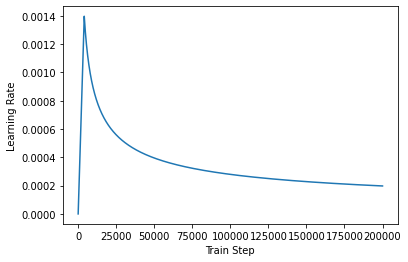

In [32]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [33]:
bert = BERT(num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate)

checkpoint_path = "./checkpoints/finetune_balanced"

ckpt = tf.train.Checkpoint(bert=bert,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

logits_lm, logits_clsf = bert(input_ids, segment_ids, masked_pos,
                                 training = False, pretraining = False)

Latest checkpoint restored!!


In [ ]:
EPOCHS = 200

# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.
# (32, 150, 7) (32, 150) (32,)
train_step_signature = [
    tf.TensorSpec(shape=(32, 150, 7), dtype=tf.float32),
    tf.TensorSpec(shape=(32, 150), dtype=tf.float32),
    tf.TensorSpec(shape=(32,), dtype=tf.float32),
]

@tf.function(input_signature=train_step_signature)
def train_step(input_ids, segment_ids, label):
  weight_for_0 = (1 / (tf.math.reduce_sum(tf.cast(label==0, dtype=tf.float32))+1e-5)) * (len(label) / 2.0) 
  weight_for_1 = (1 / (tf.math.reduce_sum(tf.cast(label==1, dtype=tf.float32))+1e-5)) * (len(label) / 2.0) / 4
  sample_weight = weight_for_0 * tf.cast(label == 0, dtype=tf.float32) + weight_for_1 * tf.cast(label == 1, dtype=tf.float32)
  #print(tf.math.reduce_sum(tf.cast(label==0, dtype=tf.float32))+1e-5, tf.math.reduce_sum(tf.cast(label==1, dtype=tf.float32))+1e-5)
  #print(label)
  #print(weight_for_0, weight_for_1)

  with tf.GradientTape() as tape:
    masked_pos = tf.zeros([tf.shape(segment_ids)[0], 22])
    logits_lm, logits_clsf = bert(input_ids, segment_ids, masked_pos,
                                 training = True, pretraining = False)
    loss = SCCE(label, logits_clsf, sample_weight=sample_weight) + MSE(input_ids, logits_lm)
    #print(logits_clsf)
    #tf.print(SCCE(label, logits_clsf).numpy)
    #tf.print(MSE(input_ids, logits_lm).numpy)
    #print()

  gradients = tape.gradient(loss, bert.trainable_variables)
  optimizer.apply_gradients(zip(gradients, bert.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(label, logits_clsf))
  prediction = tf.math.argmax(logits_clsf, axis=1)
  train_precision(label, prediction)
  train_recall(label, prediction)
  train_roc_auc(label, tf.nn.softmax(logits_clsf, axis=1)[:, 1])
  #tf.print(tf.shape(tf.nn.softmax(logits_clsf, axis=1)[:, 1]))
  #tf.print(tf.shape(label))
  #tf.print(tf.constant(tf.keras.utils.to_categorical(label.numpy(), num_classes=2, dtype='float32')))
  train_f1_score(tf.constant(tf.keras.utils.to_categorical(label.numpy(), num_classes=2, dtype='float32')), tf.nn.softmax(logits_clsf, axis=1))

@tf.function(input_signature=train_step_signature)
def test_step(input_ids, segment_ids, label):
  weight_for_0 = (1 / (tf.math.reduce_sum(tf.cast(label==0, dtype=tf.float32))+1e-5)) * (len(label) / 2.0)
  weight_for_1 = (1 / (tf.math.reduce_sum(tf.cast(label==1, dtype=tf.float32))+1e-5)) * (len(label) / 2.0) / 4
  sample_weight = weight_for_0 * tf.cast(label == 0, dtype=tf.float32) + weight_for_1 * tf.cast(label == 1, dtype=tf.float32)

  masked_pos = tf.zeros([tf.shape(segment_ids)[0], 22])
  logits_lm, logits_clsf = bert(input_ids, segment_ids, masked_pos, training = False, pretraining = False)
  loss = SCCE(label, logits_clsf, sample_weight=sample_weight) + MSE(input_ids, logits_lm)
  #print(label)
  #print(logits_clsf)
    
  test_loss(loss)
  test_accuracy(accuracy_function(label, logits_clsf))
  prediction = tf.math.argmax(logits_clsf, axis=1)
  test_precision(label, prediction)
  test_recall(label, prediction)
  test_roc_auc(label, tf.nn.softmax(logits_clsf, axis=1)[:, 1])
  test_f1_score(tf.constant(tf.keras.utils.to_categorical(label.numpy(), num_classes=2, dtype='float32')), tf.nn.softmax(logits_clsf, axis=1))

In [ ]:
# Debug mode
tf.config.run_functions_eagerly(True)

for epoch in range(EPOCHS):    
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()
  train_precision.reset_states()
  train_recall.reset_states()
  train_roc_auc.reset_states()
  train_f1_score.reset_states()

  # training
  print("training...")
  for (batch, (input_ids, segment_ids, label)) in enumerate(token_dataset_train):
    train_step(input_ids, segment_ids, label)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f} Precision {train_precision.result():.4f} Recall {train_recall.result():.4f} ROC_AUC {train_roc_auc.result():.4f} F1_score {train_f1_score.result()[1]:.4f}')
    
  if (epoch + 1) % 10 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f} Precision {train_precision.result():.4f} Recall {train_recall.result():.4f} ROC_AUC {train_roc_auc.result():.4f} F1_score {train_f1_score.result()[1]:.4f}')

  test_loss.reset_states()
  test_accuracy.reset_states()
  test_precision.reset_states()
  test_recall.reset_states()
  test_roc_auc.reset_states()
  test_f1_score.reset_states()

  # testing
  print("testing...")
  for (batch, (input_ids, segment_ids, label)) in enumerate(token_dataset_test):
    test_step(input_ids, segment_ids, label)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {test_loss.result():.4f} Accuracy {test_accuracy.result():.4f} Precision {test_precision.result():.4f} Recall {test_recall.result():.4f} ROC_AUC {test_roc_auc.result():.4f} F1_score {test_f1_score.result()[1]:.4f}')

  print(f'Epoch {epoch + 1} Loss {test_loss.result():.4f} Accuracy {test_accuracy.result():.4f} Precision {test_precision.result():.4f} Recall {test_recall.result():.4f} ROC_AUC {test_roc_auc.result():.4f} F1_score {test_f1_score.result()[1]:.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

In [ ]:
Y_hat = []
Y_true = []
test_time = True

for (batch, (input_ids, segment_ids, label)) in enumerate(token_dataset_test):
    if test_time:
        test_time = False
        cur_time = time.time()
        logits_lm, logits_clsf = bert(tf.expand_dims(input_ids[0], 0), tf.expand_dims(segment_ids[0], 0), 
                                      tf.expand_dims(masked_pos[0], 0), training = False, pretraining = False)
        print("time: (ms)", (time.time() - cur_time) * 1000)
    logits_lm, logits_clsf = bert(input_ids, segment_ids, masked_pos, training = False, pretraining = False)
    Y_hat.append(logits_clsf)
    Y_true.append(label)

Y_hat = np.array(Y_hat).reshape(-1, 2)
Y_true = np.array(Y_true).reshape(-1)

print("accuracy: ", accuracy_score(Y_true, np.argmax(Y_hat, axis=1)))
print("precision: ", precision_score(Y_true, np.argmax(Y_hat, axis=1)))
print("recall: ", recall_score(Y_true, np.argmax(Y_hat, axis=1)))
print("roc auc: ", roc_auc_score(Y_true, Y_hat[:, 1]))
print("f1: ", f1_score(Y_true, np.argmax(Y_hat, axis=1)))

In [35]:
X_test_filled = np.concatenate((X_test, np.zeros((16, 148, 7))), axis=0)
X_test_batch = np.split(X_test_filled, 32)
Y_hat = []

for X_batch in X_test_batch:
    masked_pos = tf.zeros([tf.shape(X_batch)[0], 22])
    input_ids = np.concatenate((np.ones((X_batch.shape[0], 1, 7)), X_batch,  np.ones((X_batch.shape[0], 1, 7))*-1), axis=1)
    segment_ids = np.zeros((X_batch.shape[0], X_batch.shape[1]+2))
    logits_lm, logits_clsf = bert(input_ids, segment_ids, masked_pos, training = False, pretraining = False)
    Y_hat.append(logits_clsf)
    
Y_hat = np.array(Y_hat).reshape(-1, 2)[:-16]

statistical_test_output["BERT"] = Y_hat

In [41]:
print(scipy.stats.ttest_rel(statistical_test_output["BERT"], statistical_test_output["LR"], axis=None))
print(scipy.stats.ttest_rel(statistical_test_output["BERT"], statistical_test_output["RF"], axis=None))
print(scipy.stats.ttest_rel(statistical_test_output["BERT"], statistical_test_output["SVM"], axis=None))
print(scipy.stats.ttest_rel(statistical_test_output["BERT"], statistical_test_output["XGBoost"], axis=None))

Ttest_relResult(statistic=-90.71201862238942, pvalue=0.0)
Ttest_relResult(statistic=-89.92940358174775, pvalue=0.0)
Ttest_relResult(statistic=-92.63564831257575, pvalue=0.0)
Ttest_relResult(statistic=-95.82285235450556, pvalue=0.0)
